# Data Preparation

## Cleaning/Simple EDA


In [20]:
# ------------- standard library -------------
import warnings
from collections import Counter

# ------------- 3rd-party core ---------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm

# ------------- scikit-learn -----------------
# model selection / metrics
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, confusion_matrix,
    r2_score, mean_squared_error, mean_absolute_error,
    make_scorer, get_scorer
)

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# feature selection
from sklearn.feature_selection import (
    SelectKBest, RFE,
    f_classif, f_regression,
    mutual_info_classif, mutual_info_regression
)

# estimators
from sklearn.ensemble import (
    VotingClassifier, StackingClassifier,
    GradientBoostingClassifier, GradientBoostingRegressor,
    RandomForestClassifier, RandomForestRegressor,
    VotingClassifier, StackingClassifier
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# ------------- imbalanced-learn -------------
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# ------------- boosting libraries ----------
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ------------- hyper-parameter tuning ------
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ------------- extra / mlxtend --------------
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# ------------- local helpers ---------------
from function_helper2 import (
    kbest_evaluate_features,
    rfe_evaluate_features,
    sffs_sbfs_evaluate_features,
    train_and_evaluate_resampled
)

# ------------- global settings -------------
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

In [21]:
df = pd.read_csv('ea.csv')
print(df.shape)
df.head()

(101, 10)


,Building_ID,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps,Damage_State
0,1,10.3157,123.8854,0.45,42.1,1985,4,Masonry (CHB),250.0,Severe
1,2,10.3119,123.9065,0.52,55.3,2018,35,Steel Frame,450.0,Moderate
2,3,10.2921,123.8801,0.38,33.9,1972,2,Wood,250.0,Severe
3,4,10.3325,123.9184,0.48,49.2,2012,12,Reinforced Concrete,450.0,Light
4,5,10.3084,123.8991,0.55,58.7,1998,8,Reinforced Concrete,450.0,Moderate


In [22]:
# check data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Building_ID         101 non-null    object 
 1   Latitude            101 non-null    object 
 2   Longitude           101 non-null    object 
 3   PGA_g               101 non-null    object 
 4   PGV_cm_s            101 non-null    object 
 5   Year_Construction   101 non-null    object 
 6   Num_Stories         101 non-null    object 
 7   Structural_System   100 non-null    object 
 8   Soil_Type_Vs30_mps  100 non-null    float64
 9   Damage_State        100 non-null    object 
dtypes: float64(1), object(9)
memory usage: 8.0+ KB


In [23]:
# 1. Theres a string in our Latitude 
df[~pd.to_numeric(df['Latitude'], errors='coerce').notna()]
# get the index
to_drop = df[~pd.to_numeric(df['Latitude'], errors='coerce').notna()].index
# drop
df = df.drop(to_drop)

# 2. Theres a nan in our Year_Construction
to_drop = df[~pd.to_numeric(df['Year_Construction'], errors='coerce').notna()].index
df = df.drop(to_drop)

In [24]:
# convert to appropriate data types
# df = df.drop(columns='Building_ID')
df['Latitude']         = pd.to_numeric(df['Latitude'], errors='coerce') 
df.Longitude           = pd.to_numeric(df['Longitude'], errors='coerce') 
df.PGA_g               = pd.to_numeric(df['PGA_g'], errors='coerce') 
df.PGV_cm_s            = pd.to_numeric(df['PGV_cm_s'], errors='coerce') 
df.Year_Construction   = df.Year_Construction.astype('int64')
df.Num_Stories         = pd.to_numeric(df['Num_Stories'], errors='coerce') 
df.Structural_System   = df.Structural_System.astype('category') # unordered category

# df.Soil_Type_Vs30_mps  = df.Soil_Type_Vs30_mps.astype('category') # unordered category
df.Soil_Type_Vs30_mps  = df.Soil_Type_Vs30_mps.astype('int64') 

damage_state_order = ['No Damage', 'Light', 'Moderate',  'Severe', 'Collapse' ]
df.Damage_State        = pd.Categorical(df.Damage_State , damage_state_order, ordered=True)

In [25]:
# verify
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 100
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Building_ID         100 non-null    object  
 1   Latitude            100 non-null    float64 
 2   Longitude           100 non-null    float64 
 3   PGA_g               100 non-null    float64 
 4   PGV_cm_s            100 non-null    float64 
 5   Year_Construction   100 non-null    int64   
 6   Num_Stories         100 non-null    int64   
 7   Structural_System   100 non-null    category
 8   Soil_Type_Vs30_mps  100 non-null    int64   
 9   Damage_State        100 non-null    category
dtypes: category(2), float64(4), int64(3), object(1)
memory usage: 7.6+ KB


In [26]:
# check the target variable
print(df.Damage_State.unique()) # in order

# check the target proportion (if imbalance use SMOTE)
df.Damage_State.value_counts()

['Severe', 'Moderate', 'Light', 'Collapse', 'No Damage']
Categories (5, object): ['No Damage' < 'Light' < 'Moderate' < 'Severe' < 'Collapse']


Damage_State
Moderate     34
Light        28
Severe       20
No Damage     9
Collapse      9
Name: count, dtype: int64

Box plots generated for all numeric features, comparing 'Severe' and 'Collapse'.


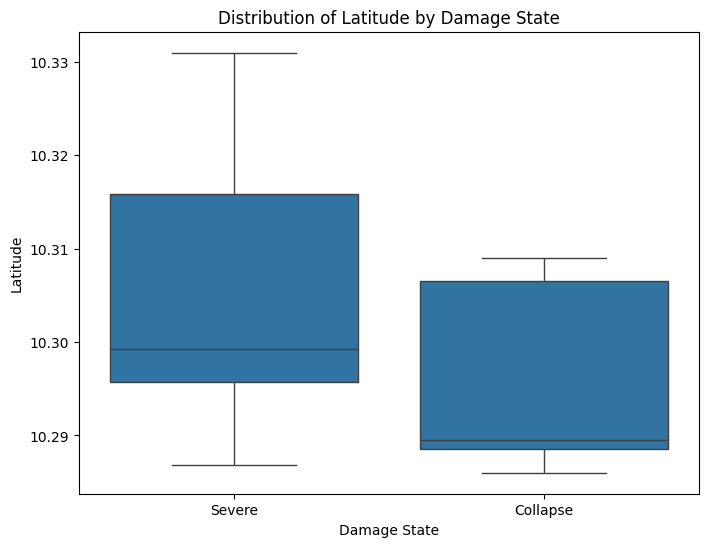

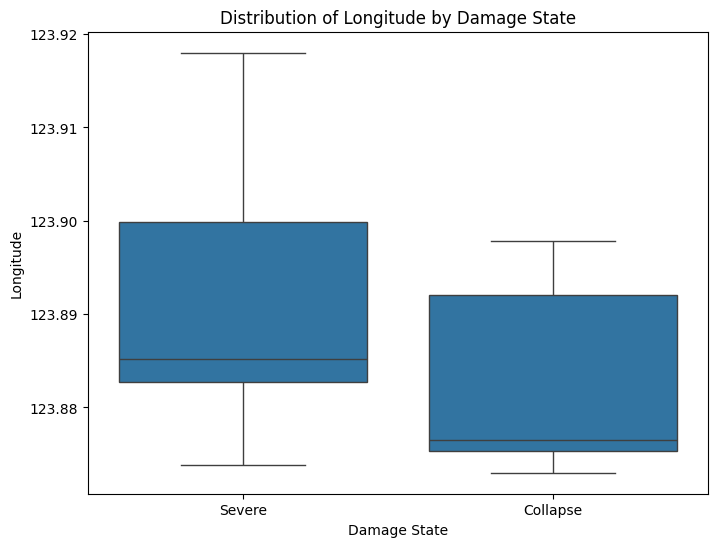

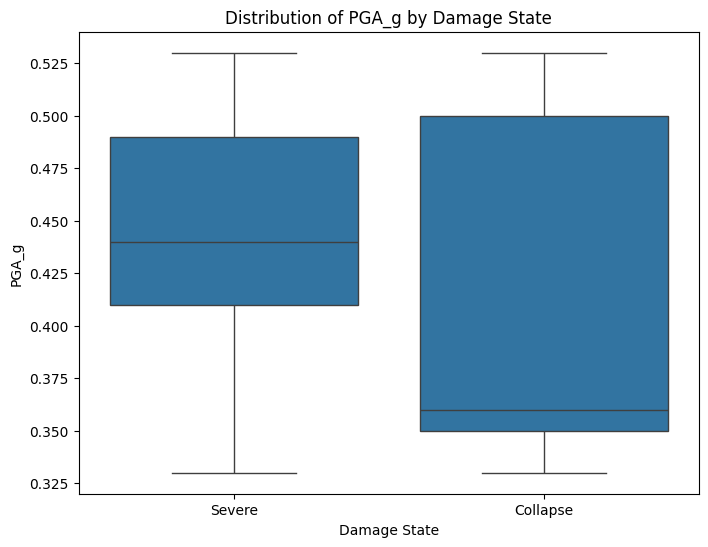

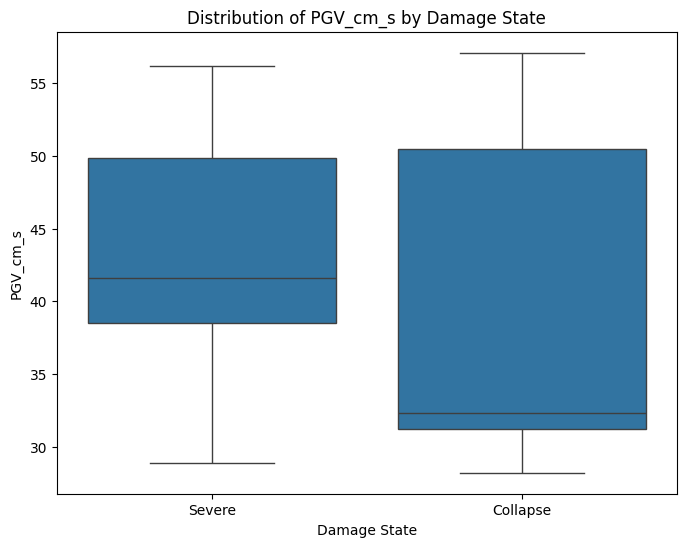

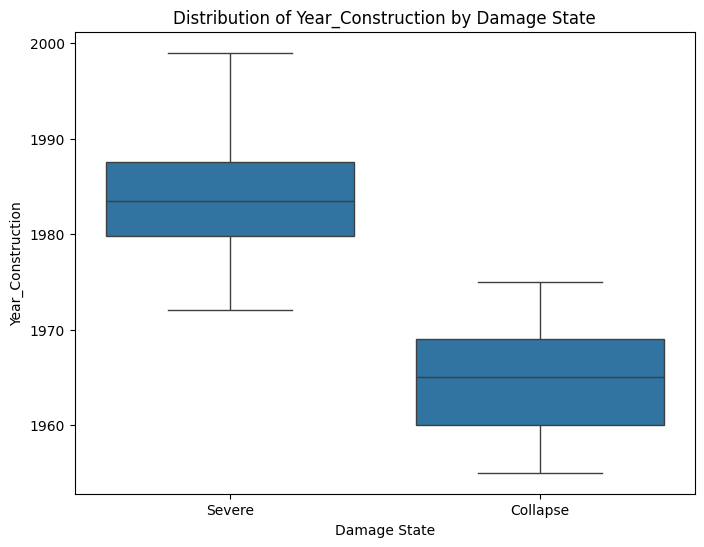

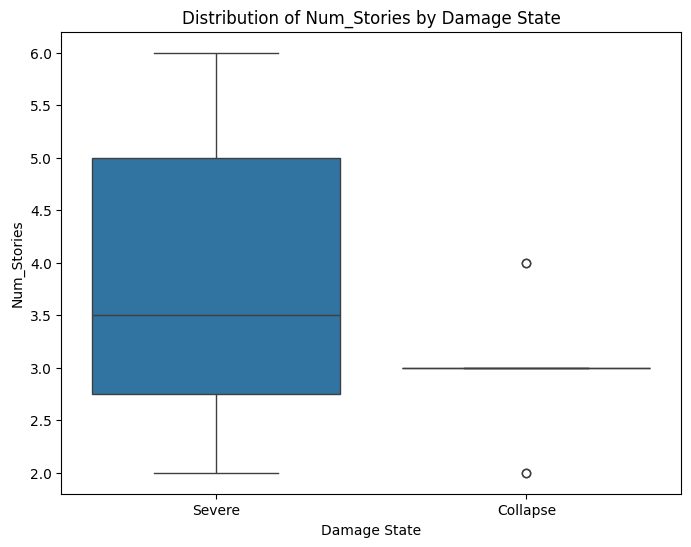

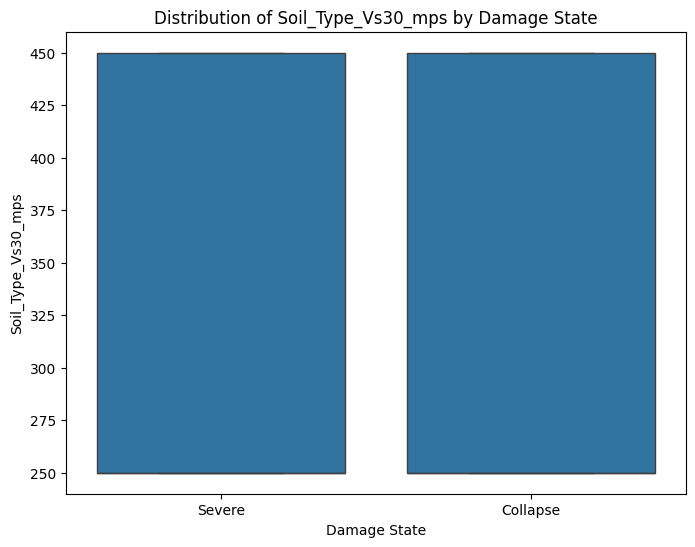

In [27]:
# Check wether the 'severe' and 'collapse' category does share the same information

# 1. Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.to_list()

# 2. Filter the DataFrame to include only 'Severe' and 'Collapse' for plotting
df_filtered = df[df['Damage_State'].isin(['Severe', 'Collapse'])].copy()

# 3. Create a box plot for every numeric feature
for feature in numeric_cols:
    plt.figure(figsize=(8, 6))
    
    # Use 'Damage_State' on the x-axis and the numeric feature on the y-axis
    sns.boxplot(
        x='Damage_State', 
        y=feature, 
        data=df_filtered, 
        order=['Severe', 'Collapse'] # Ensure consistent order
    )
    
    plt.title(f'Distribution of {feature} by Damage State')
    plt.xlabel('Damage State')
    plt.ylabel(feature)
    
    # Save the plot for review
    # We use a unique name for each plot file
    # plt.savefig(f'boxplot_{feature}.png')
    # plt.close()

print("Box plots generated for all numeric features, comparing 'Severe' and 'Collapse'.")

In [28]:
# This visualization show that severe and colapse are not the same 
# For more EDA we can perform A and B Test if necessary

In [29]:
# proportion of null values
df.isnull().sum()/len(df)

Building_ID           0.0
Latitude              0.0
Longitude             0.0
PGA_g                 0.0
PGV_cm_s              0.0
Year_Construction     0.0
Num_Stories           0.0
Structural_System     0.0
Soil_Type_Vs30_mps    0.0
Damage_State          0.0
dtype: float64

In [30]:
# Summary statistics
df.describe()

,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Soil_Type_Vs30_mps
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,10.313768,123.901097,0.447100,44.417000,1999.54000,9.060000,426.500000
std,0.018121,0.018057,0.079064,10.421879,17.38885,8.266789,159.932909
min,10.286000,123.873000,0.250000,22.100000,1955.00000,1.000000,250.000000
25%,10.298750,123.885300,0.387500,34.475000,1987.75000,3.000000,250.000000
50%,10.313650,123.899300,0.470000,47.350000,2002.50000,6.000000,450.000000
75%,10.326500,123.916250,0.510000,52.550000,2015.00000,12.000000,450.000000
max,10.351000,123.940000,0.560000,60.100000,2023.00000,40.000000,800.000000


**Visualization**

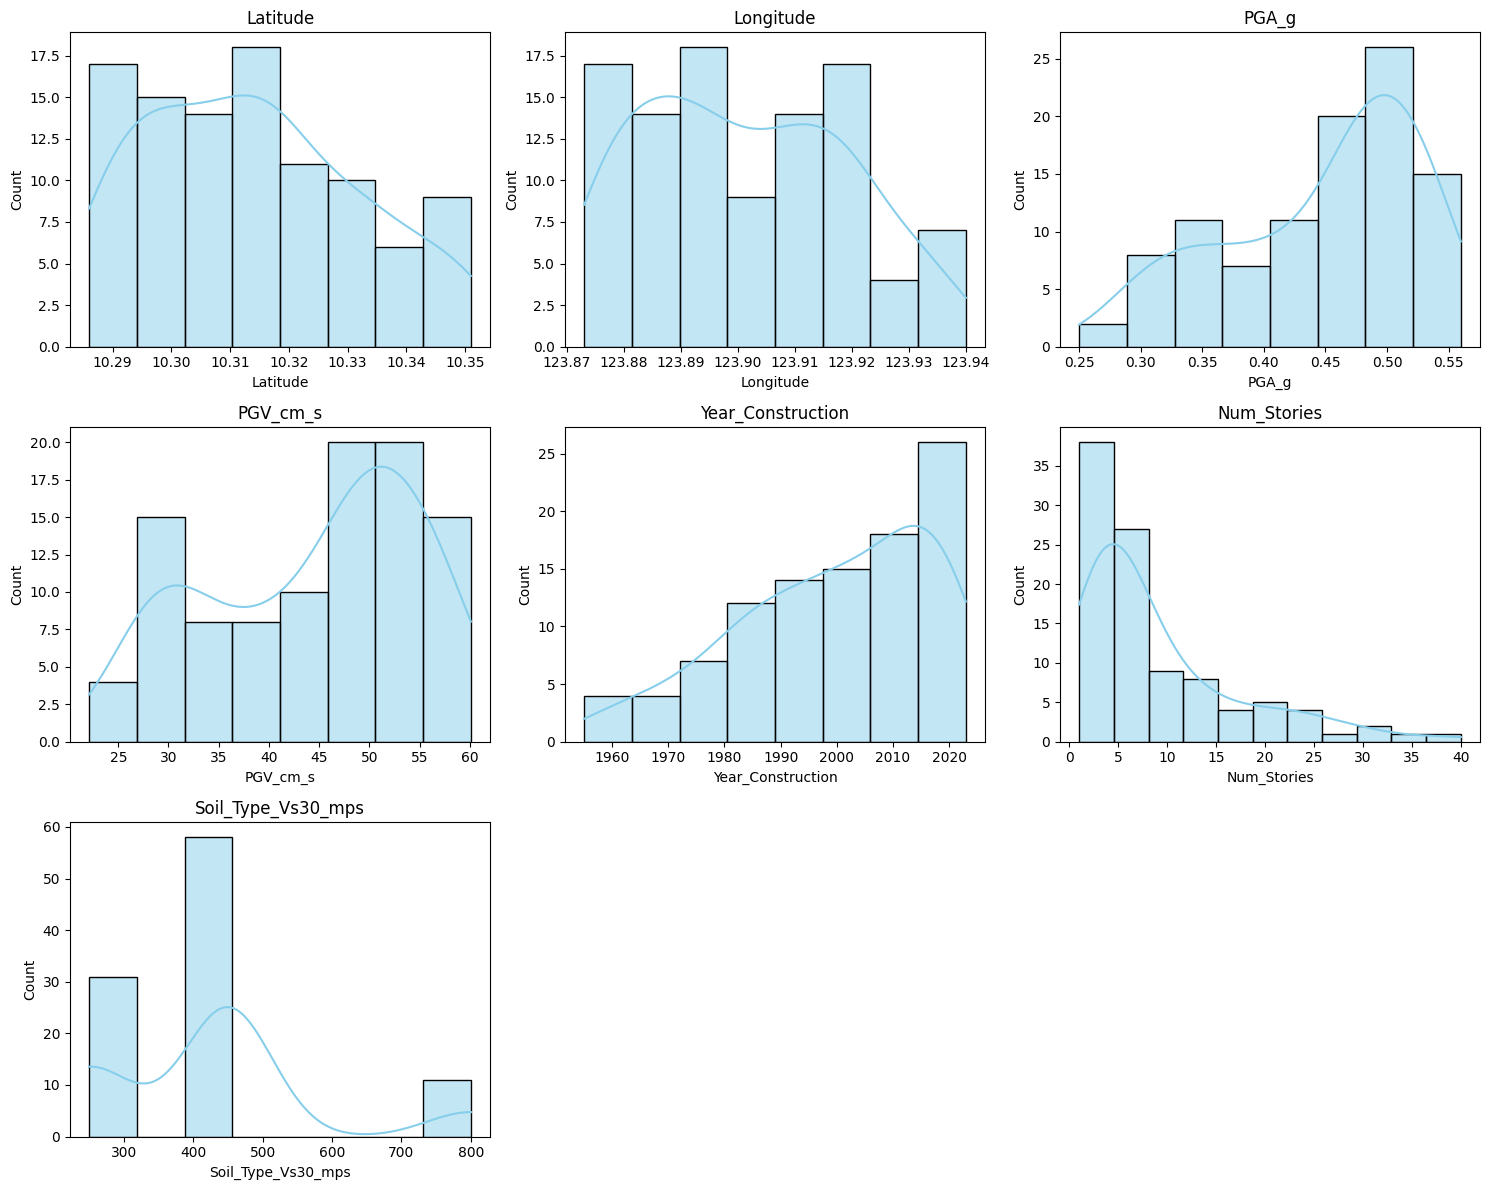

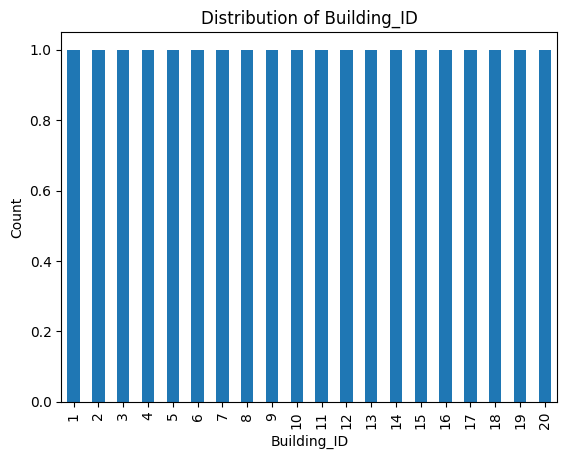

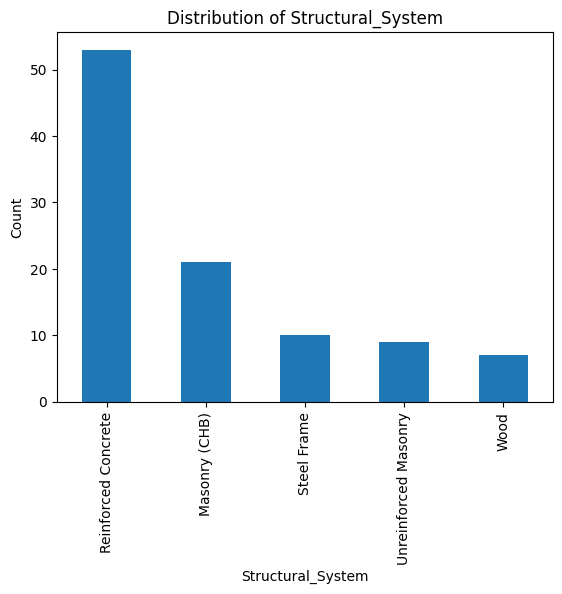

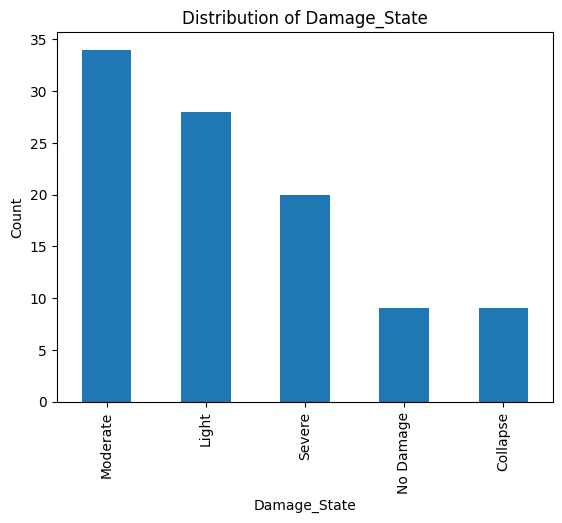

In [31]:
from function_helper2 import plot_distributions
plot_distributions(df)

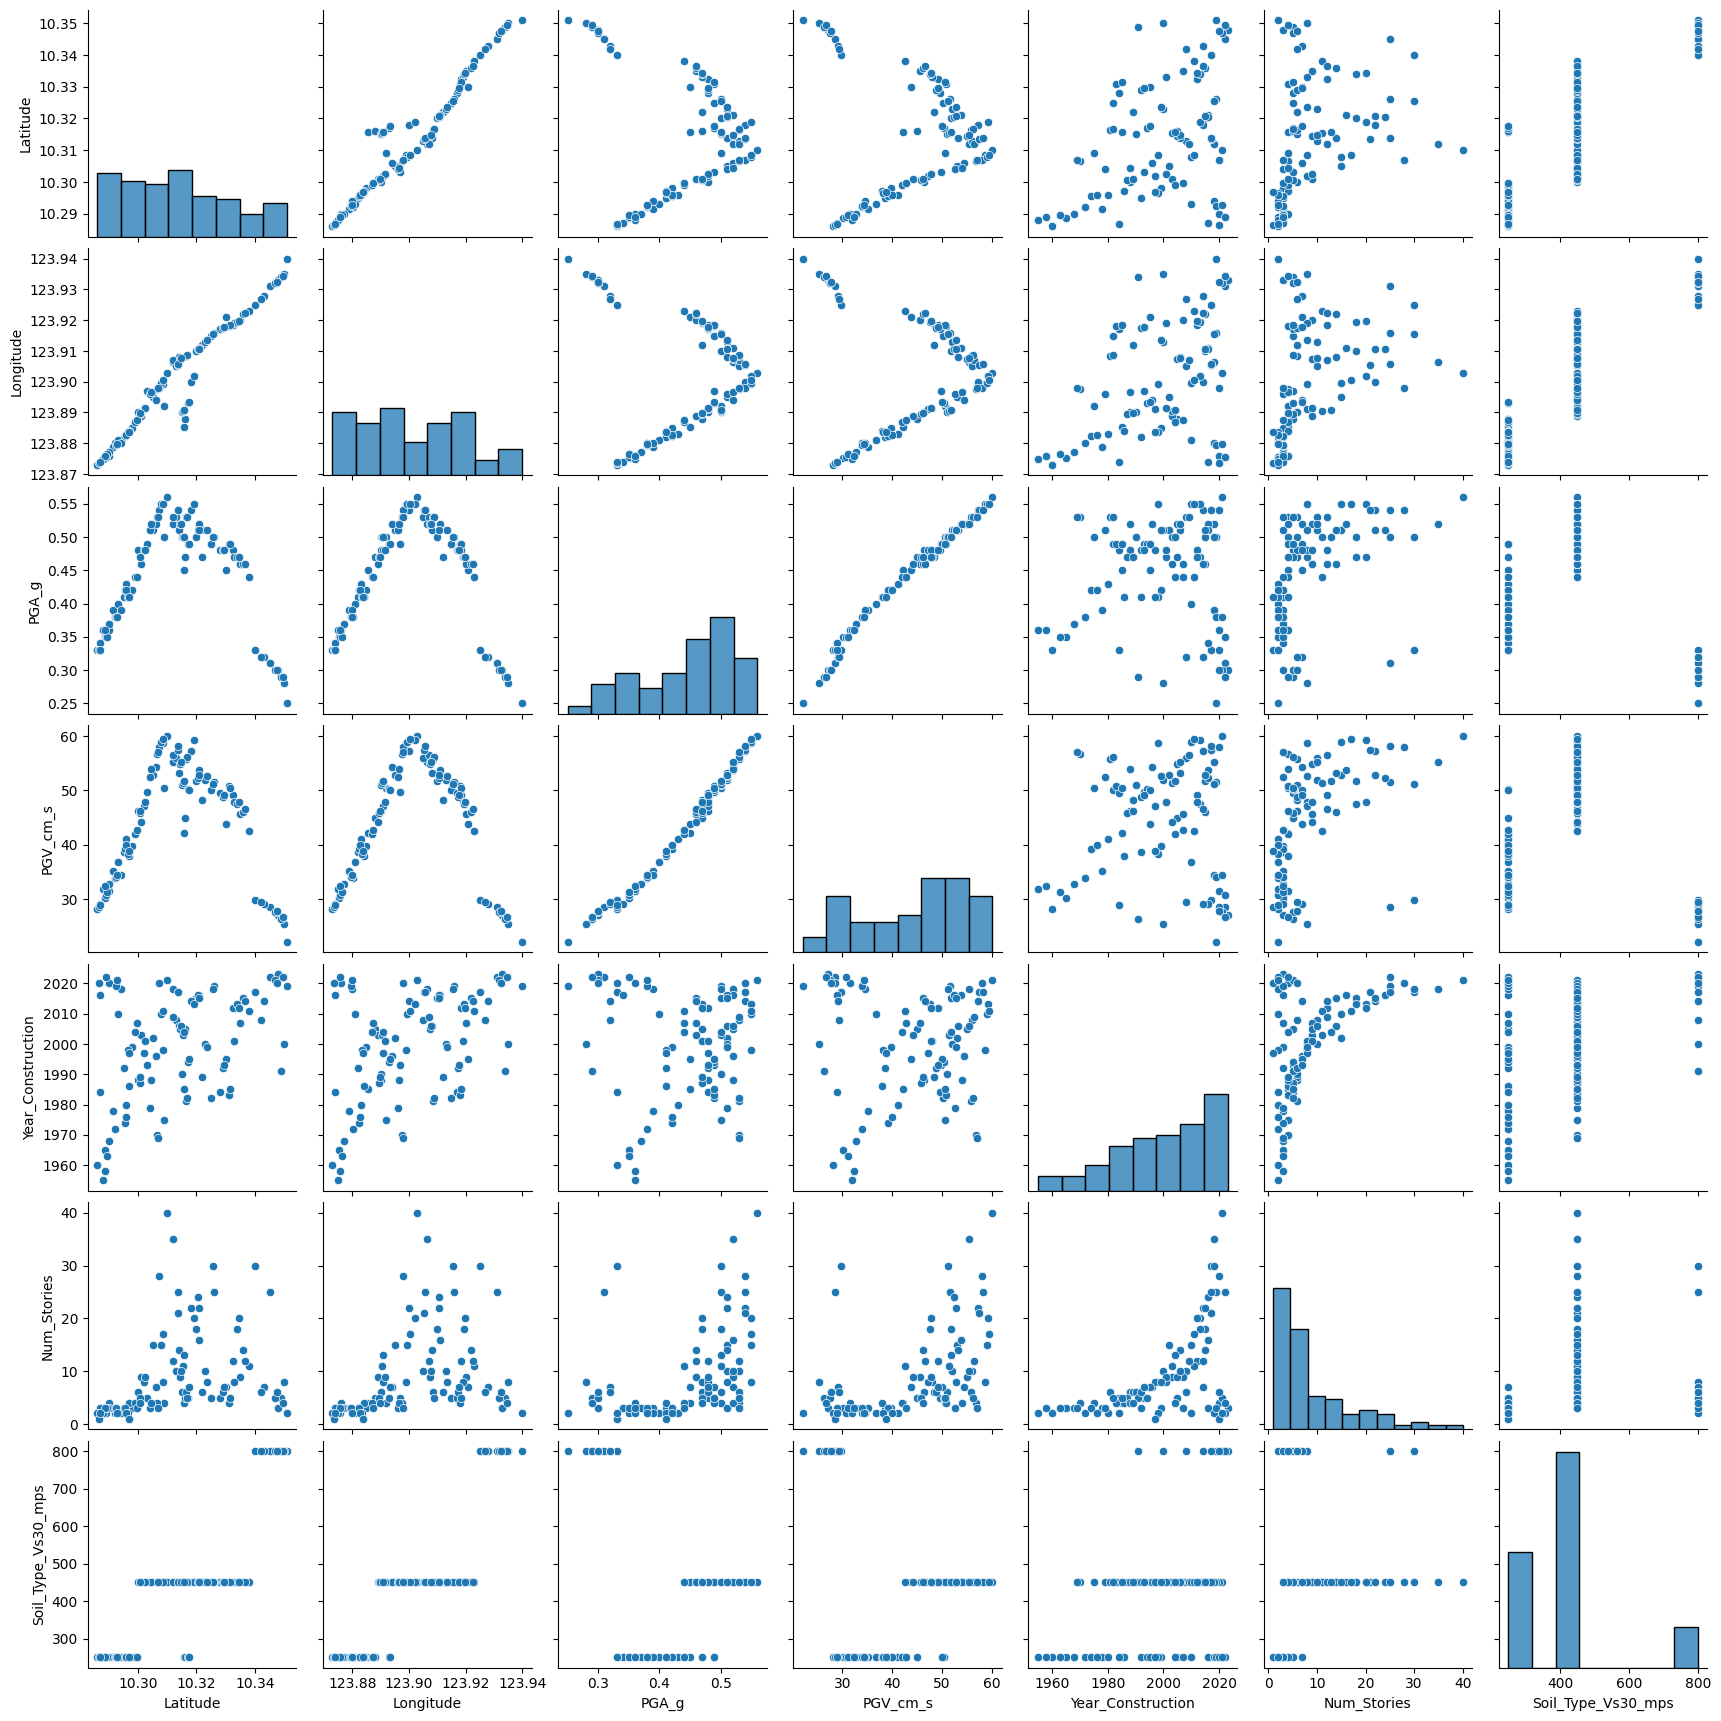

In [32]:
sns.pairplot(df, diag_kind='hist')   # diagonal = distribution
plt.show()

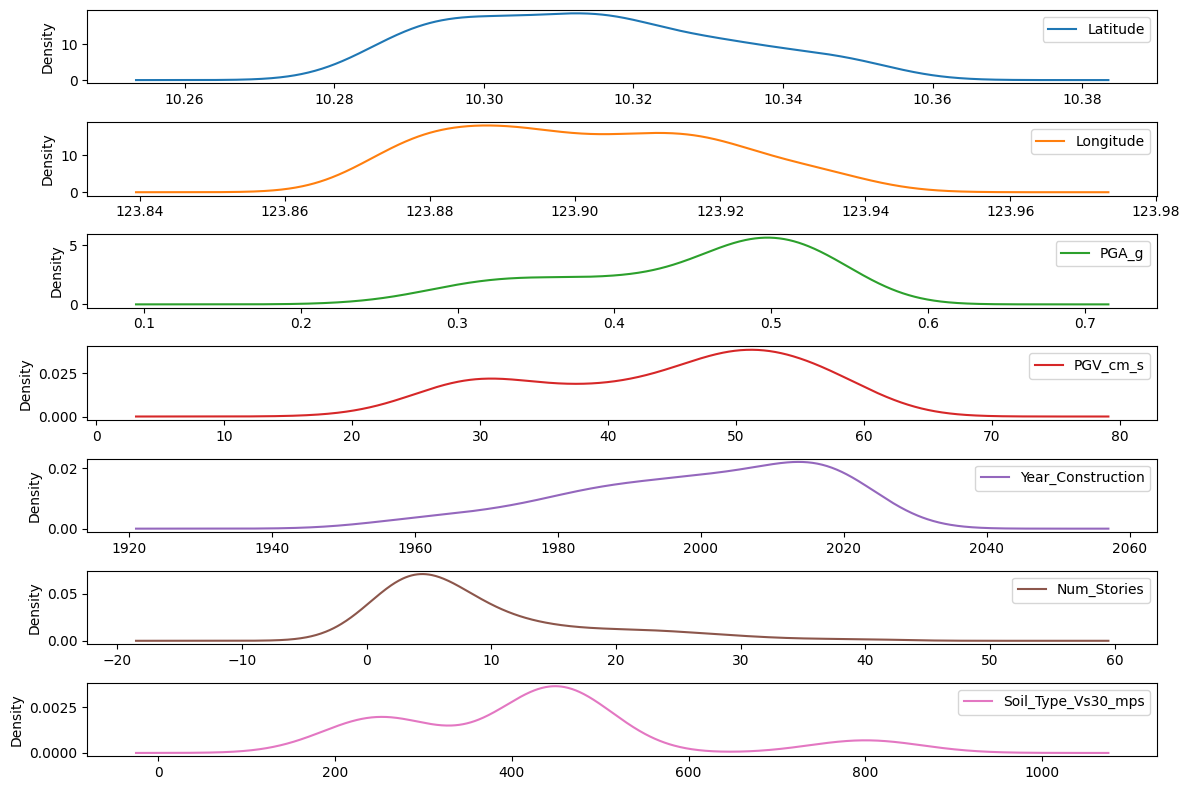

In [33]:
df.plot.kde(subplots=True, figsize=(12, 8), sharex=False)
plt.tight_layout()
plt.show()

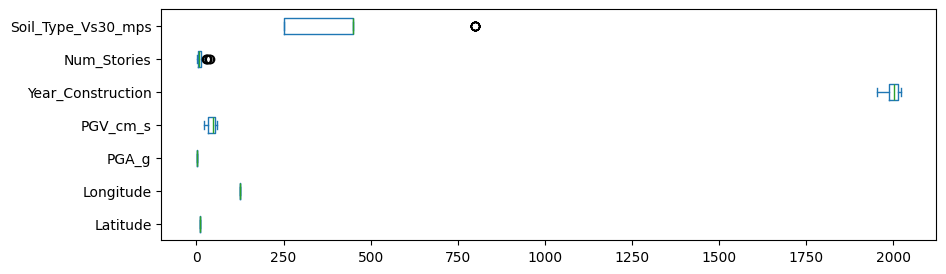

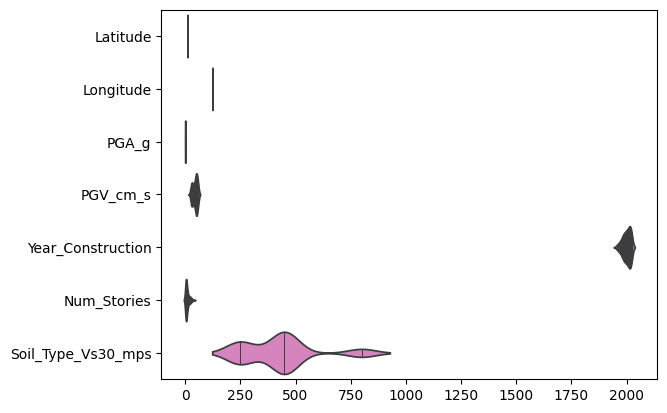

In [34]:
# box
df.plot.box(vert=False, figsize=(10, 0.3*len(df.columns)))
plt.show()

# violin
import seaborn as sns
sns.violinplot(data=df, orient='h', inner='stick')
plt.show()

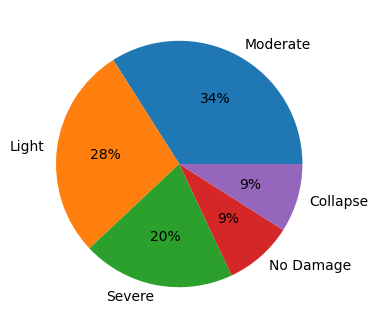

In [35]:
# check if we have balance target category again in visualzation
df.Damage_State.value_counts().plot.pie(autopct='%1.0f%%', figsize=(4,4))
plt.ylabel("")          # removes the default "Damage_State" label
plt.show()

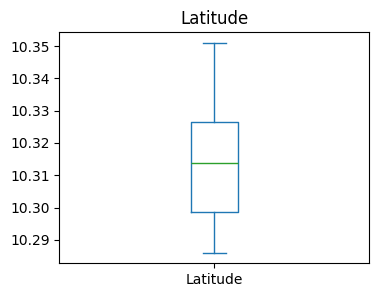

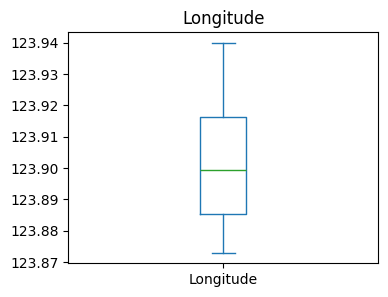

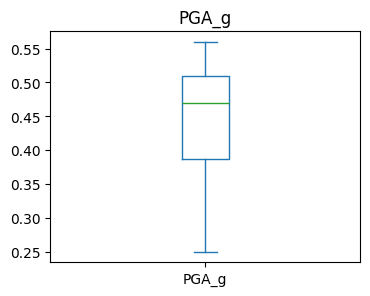

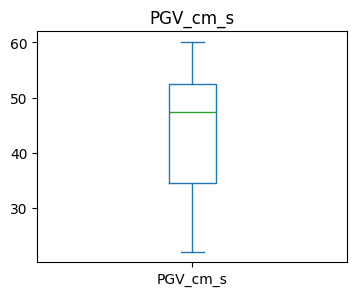

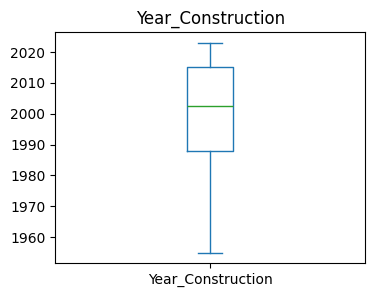

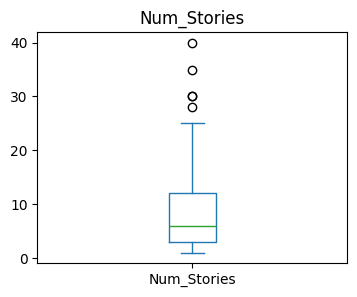

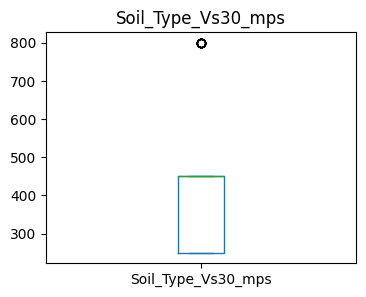

In [36]:
# before we perform smote lets check for outliers

# pick only the numeric columns
num_cols = df.select_dtypes(include='number')
for col in num_cols.columns:
    plt.figure(figsize=(4,3))
    num_cols[col].plot.box()
    plt.title(col)
    plt.show()

---

# Model Selection

## Manual Configuration

In [37]:
# Assume df is your DataFrame
X = df.drop(columns=['Building_ID', 'Damage_State']) 
y = df['Damage_State']

# targe variable is categorical ordinal data type (multi classification)
Damage_State_Mapping = {
    'No Damage': 0,
    'Light': 1,
    'Moderate': 2,
    'Severe': 3,
    'Collapse': 4
}

y_encoded = y.map(Damage_State_Mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)


# from best_gb in Ensemble technique {'n_estimators': 403, 'learning_rate': 0.12054568787134347, 'max_depth': 3
model = GradientBoostingClassifier(**best_gb, random_state=42)

# Simplier model 
# model = LogisticRegression(solver='lbfgs', penalty='l2', C=1.5876484749852176)

numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns

# SMOTENC needs to know the indices of the original categorical features
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)


# If **'smotenc'**: resampler -> preprocessor -> model.
# If **'smote'**: preprocessor -> resampler -> model.
# If **None**: preprocessor -> model.
# resample -> preprocessor -> classifier
pipe = ImbPipeline(steps=[
    ('resampler', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('preprocessor', preprocessor),
    ('classifier', model)
])

print("Training the pipeline...")
pipe.fit(X_train, y_train)
print("Training complete.")


NameError: name 'best_gb' is not defined

In [45]:
pipe

,steps,"[('resampler', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categorical_features,[6]
,categorical_encoder,None
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'


In [46]:
# Evaluate the pipeline on the untouched test data
print("\n--- Model Evaluation on Test Set ---")
accuracy = pipe.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


--- Model Evaluation on Test Set ---
Test Accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.83      1.00      0.91         5
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2

    accuracy                           0.95        20
   macro avg       0.97      0.97      0.97        20
weighted avg       0.96      0.95      0.95        20



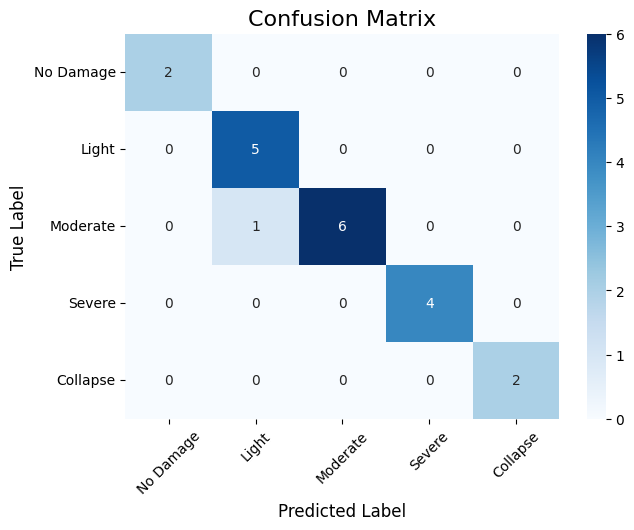

In [47]:
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
class_names = list(Damage_State_Mapping.keys())
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

**save**

In [48]:
import joblib

filename = 'damage_state_pipeline.joblib'
joblib.dump(pipe, filename)
print(f"\n✅ Pipeline successfully saved to '{filename}'")


✅ Pipeline successfully saved to 'damage_state_pipeline.joblib'


## Testing

In [147]:
df = pd.read_csv('ea.csv')
print(df.shape)
df.head()

(101, 10)


,Building_ID,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps,Damage_State
0,1,10.3157,123.8854,0.45,42.1,1985,4,Masonry (CHB),250.0,Severe
1,2,10.3119,123.9065,0.52,55.3,2018,35,Steel Frame,450.0,Moderate
2,3,10.2921,123.8801,0.38,33.9,1972,2,Wood,250.0,Severe
3,4,10.3325,123.9184,0.48,49.2,2012,12,Reinforced Concrete,450.0,Light
4,5,10.3084,123.8991,0.55,58.7,1998,8,Reinforced Concrete,450.0,Moderate


- The SMOTENC resampler in our pipeline is only active during **training (.fit())** and is **automatically bypassed during prediction (.predict())**.

- This is the correct and intended behavior of an imblearn pipeline, and we don't have to do anything to configure it

In [66]:
loaded_pipe = joblib.load('damage_state_pipeline.joblib')
loaded_pipe

,steps,"[('resampler', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categorical_features,[6]
,categorical_encoder,None
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'


In [148]:
# lets say we have 30 seismic sensors deployed
sample = df.sample(30)
sample_X = sample.drop(columns=['Building_ID', 'Damage_State'])

pred_encoded = loaded_pipe.predict(sample_X)
reverse_damage_map = {0: 'No Damage',
                      1: 'Light',
                      2: 'Moderate',
                      3: 'Severe',
                      4: 'Collapse'}
pred_labeled = [reverse_damage_map[p] for p in pred_encoded]

# 4. add predictions to the ORIGINAL 20-row sample
sample_X = sample_X.copy()                # avoids SettingWithCopyWarning
sample_X['Predicted_Damage'] = pred_labeled

In [149]:
sample_X.head()

,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps,Predicted_Damage
84,10.3138,123.9058,0.54,58.2,2017,25,Steel Frame,450.0,Light
10,10.3001,123.8902,0.48,46.3,1988,6,Reinforced Concrete,450.0,Moderate
89,10.3475,123.9325,0.30,27.8,2020,6,Reinforced Concrete,800.0,No Damage
30,10.2960,123.8830,0.43,41.1,1980,2,Wood,250.0,Severe
69,10.3065,123.8975,0.53,56.8,1970,4,Unreinforced Masonry,450.0,Collapse


In [133]:
# df.head(10)

In [ ]:
# These two parameters, PGA and PGV, are crucial for engineers to assess the potential damage to structures. 
# High PGA values are often associated with damage to short, stiff buildings, 
# while high PGV values are more indicative of damage to taller, more flexible structures

In [131]:
import pandas as pd
import folium
from io import StringIO

# 1. Recreate your DataFrame from the provided data
data = """Building_ID,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps,Damage_State
1,10.3157,123.8854,0.45,42.1,1985,4,Masonry (CHB),250,Severe
2,10.3119,123.9065,0.52,55.3,2018,35,Steel Frame,450,Moderate
3,10.2921,123.8801,0.38,33.9,1972,2,Wood,250,Severe
4,10.3325,123.9184,0.48,49.2,2012,12,Reinforced Concrete,450,Light
5,10.3084,123.8991,0.55,58.7,1998,8,Reinforced Concrete,450,Moderate
6,10.2885,123.8753,0.35,30.1,1965,3,Unreinforced Masonry,250,Collapse
7,10.3451,123.9312,0.31,28.5,2022,25,Reinforced Concrete,800,Light
"""
df = pd.read_csv(StringIO(data))

# 2. Define a color scheme for the different damage states
color_map = {
    'Light': 'green',
    'Moderate': 'orange',
    'Severe': 'red',
    'Collapse': 'black'
}

# 3. Create a base map, centered on the average coordinates of your buildings
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
building_map = folium.Map(location=map_center, zoom_start=14)

# 4. Add a marker for each building in the DataFrame
for index, row in df.iterrows():
    # Create the text that will pop up when you click a marker
    popup_text = f"""
    <b>Building ID:</b> {row['Building_ID']}<br>
    <b>Damage State:</b> {row['Damage_State']}<br>
    <b>Structural System:</b> {row['Structural_System']}
    """
    
    # Get the color for the marker from our color map
    marker_color = color_map.get(row['Damage_State'], 'gray') # 'gray' is a default
    
    # Add the marker to the map
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=marker_color, icon='home')
    ).add_to(building_map)

# 5. Save the map to an HTML file
building_map.save("building_map.html")

print("Map has been saved to building_map.html")

Map has been saved to building_map.html


In [132]:
import pandas as pd
import folium
from io import StringIO

# 1. Recreate the complete DataFrame with the original and new data
# I've manually parsed and combined the data you provided.
data = """Building_ID,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps,Damage_State
1,10.3157,123.8854,0.45,42.1,1985,4,Masonry (CHB),250,Severe
2,10.3119,123.9065,0.52,55.3,2018,35,Steel Frame,450,Moderate
3,10.2921,123.8801,0.38,33.9,1972,2,Wood,250,Severe
4,10.3325,123.9184,0.48,49.2,2012,12,Reinforced Concrete,450,Light
5,10.3084,123.8991,0.55,58.7,1998,8,Reinforced Concrete,450,Moderate
6,10.2885,123.8753,0.35,30.1,1965,3,Unreinforced Masonry,250,Collapse
7,10.3451,123.9312,0.31,28.5,2022,25,Reinforced Concrete,800,Light
8,10.3160,123.8880,0.47,45.0,2005,5,Reinforced Concrete,250,Moderate
9,10.2950,123.8820,0.41,38.6,1992,3,Masonry (CHB),250,Severe
10,10.3200,123.9100,0.50,51.8,2015,18,Steel Frame,450,Light
"""
df = pd.read_csv(StringIO(data))

# 2. Define the color scheme for markers
color_map = {
    'Light': 'green',
    'Moderate': 'orange',
    'Severe': 'red',
    'Collapse': 'black'
}

# 3. Create the base map
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
building_map_highlighted = folium.Map(location=map_center, zoom_start=14)

# 4. Add markers AND radius highlights for each building
for index, row in df.iterrows():
    # Add the marker for every building (same as before)
    popup_text = f"<b>Building ID:</b> {row['Building_ID']}<br><b>Damage State:</b> {row['Damage_State']}"
    marker_color = color_map.get(row['Damage_State'], 'gray')
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        icon=folium.Icon(color=marker_color, icon='home')
    ).add_to(building_map_highlighted)
    
    # --- New Section: Add a radius for severely affected areas ---
    if row['Damage_State'] in ['Severe', 'Collapse']:
        folium.Circle(
            location=[row['Latitude'], row['Longitude']],
            radius=400,  # Radius in meters
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.2  # Makes the circle semi-transparent
        ).add_to(building_map_highlighted)

# 5. Save the updated map to a new HTML file
building_map_highlighted.save("building_map_highlighted.html")

print("Map with highlighted radius has been saved to building_map_highlighted.html")

Map with highlighted radius has been saved to building_map_highlighted.html


---

## Functionize Manual Configuration

In [ ]:
# Assume df is your DataFrame
X = df.drop(columns=['Building_ID', 'Damage_State']) 
y = df['Damage_State']

# targe variable is categorical ordinal data type (multi classification)
Damage_State_Mapping = {
    'No Damage': 0,
    'Light': 1,
    'Moderate': 2,
    'Severe': 3,
    'Collapse': 4
}

y_encoded = y.map(Damage_State_Mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

# model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=42)


In [ ]:
# Best LR Params: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.5876484749852176}
model = LogisticRegression(solver='lbfgs', penalty='l2', C=1.5876484749852176)
model

Pipeline Setup
1. If **'smotenc'**: resampler -> preprocessor -> model.
2. If **'smote'**: preprocessor -> resampler -> model.
3. If **None**: preprocessor -> model.

In [ ]:
# No Resampling
# for regression and multi-classification task
def build_and_evaluate_pipeline(X_train, y_train, X_test, y_test, model, task_type='classification', resampling=None):
    """
    Builds a full ML pipeline that handles both classification and regression tasks,
    with an option for resampling in classification.
    """
    # --- 1. Validate Parameters ---
    if task_type not in ['classification', 'regression']:
        raise ValueError("task_type must be 'classification' or 'regression'")
    if resampling and task_type == 'regression':
        print(f"Warning: Resampling ('{resampling}') is not applicable for regression and will be ignored.")
        resampling = None

    # --- 2. Define Preprocessor ---
    numerical_cols = X_train.select_dtypes(include=np.number).columns
    categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # --- 3. Dynamic Pipeline Construction ---
    pipeline_steps = []
    if resampling == 'smotenc':
        # (Order: resampler -> preprocessor -> model)
        # ... [logic from previous answer]
        categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
        pipeline_steps.extend([
            ('resampler', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    else: # Handles SMOTE and None
        # (Order: preprocessor -> resampler -> model)
        pipeline_steps.append(('preprocessor', preprocessor))
        if resampling == 'smote':
            pipeline_steps.append(('resampler', SMOTE(random_state=42)))
        pipeline_steps.append(('model', model))

    pipeline = ImbPipeline(steps=pipeline_steps)
    # pipeline = Pipeline(steps=pipeline_steps)

    # --- 4. Train the Model ---
    print(f"Training a {task_type} model...")
    pipeline.fit(X_train, y_train)
    print("Training complete.")

    # --- 5. Evaluate Based on Task Type ---
    print("\n--- Evaluation on Test Set ---")
    y_pred = pipeline.predict(X_test)
    scores = {}

    if task_type == 'classification':
        scores['accuracy'] = accuracy_score(y_test, y_pred)
        scores['f1_weighted'] = f1_score(y_test, y_pred, average='weighted')
        print(f"Accuracy: {scores['accuracy']:.4f}")
        print(f"F1 Score (Weighted): {scores['f1_weighted']:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    elif task_type == 'regression':
        scores['r2'] = r2_score(y_test, y_pred)
        scores['mae'] = mean_absolute_error(y_test, y_pred)
        scores['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R-squared (R²): {scores['r2']:.4f}")
        print(f"Mean Absolute Error (MAE): {scores['mae']:.2f}")
        print(f"Root Mean Squared Error (RMSE): {scores['rmse']:.2f}")

    return pipeline, scores

In [ ]:
# No resampling
class_pipeline, class_scores = build_and_evaluate_pipeline(
                                                            X_train, y_train, X_test, y_test,
                                                            model=model,
                                                            task_type='classification',
                                                            resampling=None
)

In [ ]:
# With Resampling Smotenc
class_pipeline, class_scores = build_and_evaluate_pipeline(
                                                            X_train, y_train, X_test, y_test,
                                                            model=model,
                                                            task_type='classification',
                                                            resampling='smotenc')

In [ ]:
class_pipeline

## Individual Performance

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(solver='lbfgs', penalty='l2', C=1.5876484749852176),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, alpha=0.0001, solver='adam', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

In [ ]:
def evaluate_models(
    models: dict[str, BaseEstimator],
    X_train, y_train, X_test, y_test,
    *,
    task_type: str = "classification",
    resampling: str | None = None,
) -> pd.DataFrame:
    """
    Evaluate multiple models with consistent preprocessing and resampling logic.
    Automatically computes:
      - For classification: accuracy, precision, recall, f1 (weighted)
      - For regression: r2, mae, rmse

    Parameters
    ----------
    models : dict
        Mapping {name : unfitted estimator}
    task_type : {'classification', 'regression'}
    resampling : {None, 'smote', 'smotenc'}
        'smotenc' -> resampling BEFORE preprocessing (mixed data)
        'smote'   -> resampling AFTER preprocessing (numeric only)

    Returns
    -------
    pd.DataFrame
        Evaluation metrics on train and test sets.
        Sorted by first test metric (accuracy or r2).
    """

    # ---- 1. Sanity checks ----
    if task_type not in {"classification", "regression"}:
        raise ValueError("task_type must be 'classification' or 'regression'")
    if resampling and task_type == "regression":
        print(f"Warning: resampling ('{resampling}') ignored for regression.")
        resampling = None
    if resampling not in {None, "smote", "smotenc"}:
        raise ValueError("resampling must be None, 'smote' or 'smotenc'")

    # ---- 2. Column detection & preprocessor ----
    numerical_cols = X_train.select_dtypes(include=np.number).columns
    categorical_cols = X_train.select_dtypes(include=["category", "object"]).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ],
        remainder="passthrough",
    )

    # ---- 3. Metric helpers ----
    def _score_classification(y_true, y_pred, suffix: str):
        return {
            f"accuracy_{suffix}": accuracy_score(y_true, y_pred),
            f"precision_{suffix}": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            f"recall_{suffix}": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            f"f1_weighted_{suffix}": f1_score(y_true, y_pred, average="weighted"),
        }

    def _score_regression(y_true, y_pred, suffix: str):
        return {
            f"r2_{suffix}": r2_score(y_true, y_pred),
            f"mae_{suffix}": mean_absolute_error(y_true, y_pred),
            f"rmse_{suffix}": np.sqrt(mean_squared_error(y_true, y_pred)),
        }

    _scorer = _score_classification if task_type == "classification" else _score_regression

    # ---- 4. Evaluate every model ----
    results = {}
    for name, model in tqdm(models.items(), desc="Evaluating models"):

        # Build pipeline
        steps = []
        if resampling == "smotenc":
            cat_idx = [X_train.columns.get_loc(c) for c in categorical_cols]
            steps.append(("resampler", SMOTENC(categorical_features=cat_idx, random_state=42)))
            steps.append(("preprocessor", preprocessor))
        else:
            steps.append(("preprocessor", preprocessor))
            if resampling == "smote":
                steps.append(("resampler", SMOTE(random_state=42)))

        steps.append(("model", model))

        pipe = ImbPipeline(steps)
        pipe.fit(X_train, y_train)

        # Predict and score
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)

        scores = {}
        scores.update(_scorer(y_train, y_train_pred, "train"))
        scores.update(_scorer(y_test, y_test_pred, "test"))

        results[name] = scores

    # ---- 5. Format dataframe ----
    df = pd.DataFrame.from_dict(results, orient="index")
    df.index.name = "model"
    test_cols = [c for c in df.columns if c.endswith("_test")]
    sort_by = test_cols[0]
    df = df.sort_values(sort_by, ascending=False).reset_index()

    return df

In [ ]:
# without smotenc
evaluate_models(
    models = models,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    task_type = "classification",
    resampling = None)

In [ ]:
# Smote nc
evaluate_models(
    models = models,
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    task_type = "classification",
    resampling = 'smotenc')

## Ensemble

**Set-up**

In [17]:
X = df.drop(columns=['Building_ID', 'Damage_State'])
y = df['Damage_State']

Damage_State_Mapping = {'No Damage': 0,'Light': 1,'Moderate': 2,'Severe': 3,'Collapse': 4}
y_encoded = y.map(Damage_State_Mapping)

# 1. SPLIT DATA FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 2. DEFINE PREPROCESSING & RESAMPLING STEPS (DO NOT FIT THEM YET)
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns
categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    random_state=42,
    k_neighbors=3  # <-- Add this parameter
)


scorer = make_scorer(recall_score, average='weighted')

In [18]:
# ---------- Individual Objective Functions (Refactored) -------------------

def objective_logistic(trial):
    solver = trial.suggest_categorical("solver", ["saga", "lbfgs"])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet", "none"])
    C = trial.suggest_float("C", 1e-4, 1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0) if penalty == "elasticnet" else None

    if solver == "lbfgs" and penalty not in ["l2", "none"]:
        raise optuna.exceptions.TrialPruned()

    model = LogisticRegression(
        solver=solver,
        penalty=None if penalty == "none" else penalty,
        C=C, l1_ratio=l1_ratio,
        max_iter=5000, random_state=42
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_random_forest(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 2, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        random_state=42, n_jobs=-1
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 2, 15),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        eval_metric="mlogloss", use_label_encoder=False, random_state=42
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_lgbm(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        max_depth=trial.suggest_int("max_depth", 2, 20),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        random_state=42, n_jobs=-1, verbosity=-1
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_gb(trial):
    model = GradientBoostingClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        random_state=42
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_svm(trial):
    model = SVC(
        C=trial.suggest_float("C", 1e-3, 1e3, log=True),
        kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
        gamma=trial.suggest_categorical("gamma", ["scale", "auto"]),
        probability=True, random_state=42
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

def objective_mlp(trial):
    model = MLPClassifier(
        hidden_layer_sizes=(trial.suggest_int("hidden_layer_sizes", 20, 150),),
        activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
        solver=trial.suggest_categorical("solver", ["adam", "sgd"]),
        alpha=trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        max_iter=1000, early_stopping=True, random_state=42
    )
    pipeline = ImbPipeline(steps=[('resampler', smote_nc), ('preprocessor', preprocessor), ('classifier', model)])
    return cross_val_score(pipeline, X_train, y_train, cv=3, scoring=scorer).mean()

In [19]:
def run_study(name, objective, trials=30):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=trials, show_progress_bar=True)
    print(f"🏆 Best {name} Params:", study.best_params)
    print(f"✅ Best {name} Recall (Weighted): {study.best_value:.4f}\n")
    return study.best_params

In [20]:
best_lr = run_study("LR", objective_logistic, 20)
best_rf = run_study("RF", objective_random_forest, 20)
best_xgb = run_study("XGB", objective_xgb, 20)
best_lgbm = run_study("LGBM", objective_lgbm, 20)
best_gb = run_study("GB", objective_gb, 20)
best_svc = run_study("SVC", objective_svm, 20)
best_mlp = run_study("MLP", objective_mlp, 20)

Best trial: 0. Best value: 0.888414: 100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


🏆 Best LR Params: {'solver': 'saga', 'penalty': 'elasticnet', 'C': 1.1478753096016445, 'l1_ratio': 0.3667224094633381}
✅ Best LR Recall (Weighted): 0.8884



Best trial: 2. Best value: 0.887939: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


🏆 Best RF Params: {'n_estimators': 272, 'max_depth': 6, 'min_samples_split': 7}
✅ Best RF Recall (Weighted): 0.8879



Best trial: 12. Best value: 0.913105: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


🏆 Best XGB Params: {'n_estimators': 120, 'max_depth': 11, 'learning_rate': 0.028399499503055613, 'subsample': 0.5064501068446405, 'colsample_bytree': 0.7778454075623029}
✅ Best XGB Recall (Weighted): 0.9131



Best trial: 3. Best value: 0.876543: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


🏆 Best LGBM Params: {'n_estimators': 51, 'max_depth': 12, 'learning_rate': 0.03296002669607376}
✅ Best LGBM Recall (Weighted): 0.8765



Best trial: 12. Best value: 0.913105: 100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


🏆 Best GB Params: {'n_estimators': 403, 'learning_rate': 0.12054568787134347, 'max_depth': 3}
✅ Best GB Recall (Weighted): 0.9131



Best trial: 3. Best value: 0.901235: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


🏆 Best SVC Params: {'C': 2.7940317156938628, 'kernel': 'rbf', 'gamma': 'scale'}
✅ Best SVC Recall (Weighted): 0.9012



Best trial: 13. Best value: 0.788224: 100%|██████████| 20/20 [00:03<00:00,  5.68it/s]

🏆 Best MLP Params: {'hidden_layer_sizes': 93, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.010103707047393783}
✅ Best MLP Recall (Weighted): 0.7882



In [21]:
lr = LogisticRegression(**best_lr, random_state=42)
rf = RandomForestClassifier(**best_rf, random_state=42)
xgb = XGBClassifier(**best_xgb, random_state=42)
lgbm = LGBMClassifier(**best_lgbm, random_state=42)
gb = GradientBoostingClassifier(**best_gb, random_state=42)
svc = SVC(**best_svc, 
          probability=True, # Important for soft voting!
          random_state=42)
# mlp = MLPClassifier(**best_mlp, random_state=42) # cancel this as this give a lower score

**VotingClassifier**

In [23]:
voting = VotingClassifier(
    estimators=[("lr", lr), ("rf", rf), ("xgb", xgb), ("lgbm", lgbm), ("gb", gb), ("svc", svc)],
    voting="soft" # Use predicted probabilities
)

pipeline = ImbPipeline(steps=[
    ('resampler', smote_nc),
    ('preprocessor', preprocessor),
    ('classifier', voting) # <-- Pass the unfitted 'voting' object here
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)
voting

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.1478753096016445
,fit_intercept,True


In [24]:
print(classification_report(y_test, y_pred_pipeline))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.62      1.00      0.77         5
           2       0.86      0.86      0.86         7
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2

    accuracy                           0.80        20
   macro avg       0.70      0.72      0.70        20
weighted avg       0.76      0.80      0.76        20



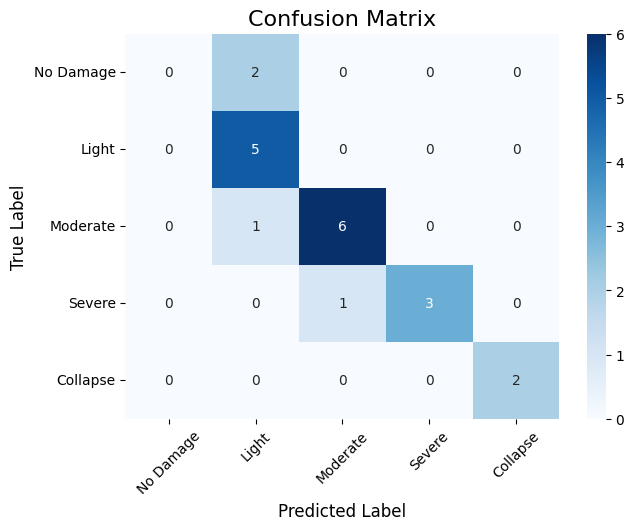

In [25]:
cm = confusion_matrix(y_test, y_pred_pipeline)
class_names = list(Damage_State_Mapping.keys())
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

**StackingClassifier Test 1**

In [29]:
# --- Step 2: Define the Stacking Classifier ---
# We provide the base models and a final model (meta-learner) to learn from them.
# The `passthrough=True` argument means the original features will also be available
# to the final_estimator, which can sometimes improve performance.

# Option 1: The standard, recommended approach
stack_lr = StackingClassifier(
    estimators=estimators,

    final_estimator=lr, # The "manager" model
    
    cv=5, # Cross-validation strategy for training the meta-learner
    passthrough=True 
)
stack_lr

,estimators,"[('lr', ...), ('rf', ...), ...]"
,final_estimator,LogisticRegre...solver='saga')
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,True
,verbose,0
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.1478753096016445


In [31]:
# --- Step 3: Define the full pipeline with the unfitted Stacking Classifier ---
pipeline = ImbPipeline(steps=[
    ('resampler', smote_nc),
    ('preprocessor', preprocessor),
    ('classifier', stack_lr) # <-- Place the unfitted stacking classifier here
])
pipeline

,steps,"[('resampler', ...), ('preprocessor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,categorical_features,[6]
,categorical_encoder,None
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,3
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'


In [32]:
# --- Step 4: Fit the entire pipeline on the training data ---
pipeline.fit(X_train, y_train)

# --- Step 5: Make predictions and evaluate the pipeline ---
y_pred_pipeline = pipeline.predict(X_test)

print("Classification Report for the Stacking Pipeline:")
print(classification_report(y_test, y_pred_pipeline))

Classification Report for the Stacking Pipeline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.71      1.00      0.83         5
           2       0.88      1.00      0.93         7
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2

    accuracy                           0.85        20
   macro avg       0.72      0.75      0.72        20
weighted avg       0.78      0.85      0.81        20



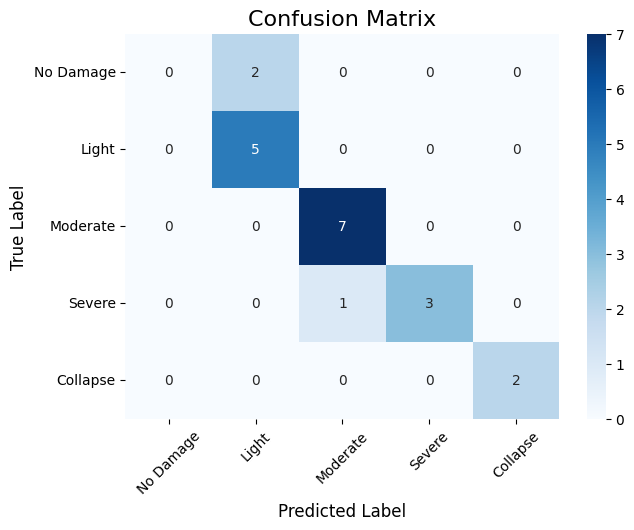

In [33]:
cm = confusion_matrix(y_test, y_pred_pipeline)
class_names = list(Damage_State_Mapping.keys())
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

**StackingClassifier Test 2**

In [34]:
# the manager 
gb

,loss,'log_loss'
,learning_rate,0.12054568787134347
,n_estimators,403
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [36]:
# Option 2: The high-performance, complex approach
stack_gb = StackingClassifier(
    estimators=estimators,
    final_estimator=gb, # Powerful, but more complex
    cv=5
)
stack_gb

,estimators,"[('lr', ...), ('rf', ...), ...]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,5
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.1478753096016445


In [38]:
# --- Step 3: Define the full pipeline with the unfitted Stacking Classifier ---
pipeline = ImbPipeline(steps=[
    # ('resampler', smote_nc),
    ('preprocessor', preprocessor),
    ('classifier', stack_gb) # <-- Place the unfitted stacking classifier here
])
pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [39]:
# --- Step 4: Fit the entire pipeline on the training data ---
pipeline.fit(X_train, y_train)

# --- Step 5: Make predictions and evaluate the pipeline ---
y_pred_pipeline = pipeline.predict(X_test)

print("Classification Report for the Stacking Pipeline:")
print(classification_report(y_test, y_pred_pipeline))

Classification Report for the Stacking Pipeline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.56      1.00      0.71         5
           2       0.83      0.71      0.77         7
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         2

    accuracy                           0.75        20
   macro avg       0.68      0.69      0.67        20
weighted avg       0.73      0.75      0.72        20



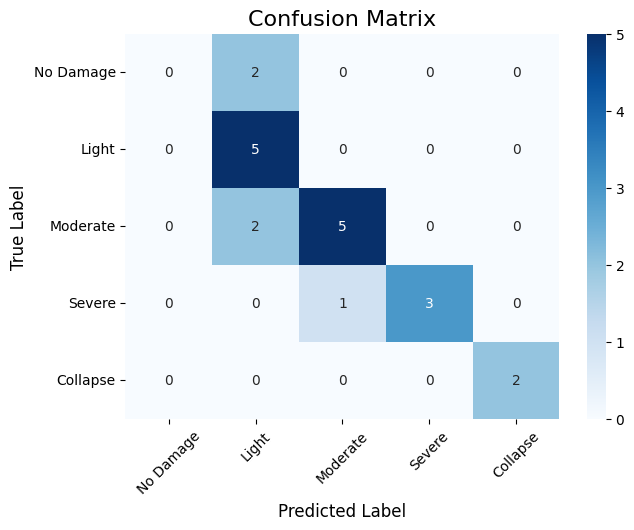

In [40]:
cm = confusion_matrix(y_test, y_pred_pipeline)
class_names = list(Damage_State_Mapping.keys())
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

---

# Feature Selection/Engineering

## SelectKBest (Filter Method)


**Function**	
1. **f_classif**: The default ANOVA F-test. It's a good general-purpose choice that measures the linear relationship between numerical features and the target.
2. **mutual_info_classif**:	A powerful choice that can capture any kind of statistical relationship, including non-linear ones. It works well with all feature types.
3. **chi2**: The chi-squared test. This is an excellent choice for your specific pipeline because it's designed for non-negative features, which is exactly what OneHotEncoder produces.

**Scoring String Metric**	
1. **'accuracy'**:	**Accuracy** -> 	The default. Good for a baseline, but can be misleading if your classes are imbalanced.
2. **'balanced_accuracy'**:	**Balanced Accuracy** ->	A great choice for imbalanced data, as it averages the recall of each class.
3. **'f1_weighted'**:	**Weighted F1-Score** ->	An excellent all-around metric that balances precision and recall while accounting for class imbalance. This is a highly recommended default.
4. **'f1_macro'**:	**Macro F1-Score** ->	Gives equal weight to each class. Use this if performance on rare classes is just as important as on common ones.
5. **'precision_weighted'**:	**Weighted Precision** ->	Use if your main goal is to minimize false positives.
6. **'recall_weighted'**:	**Weighted Recall**	-> Use if your main goal is to minimize false negative
7. **and mant more...**

**Choosing a Metric Based on Your Goal**
Here’s a guide to choosing the right metric based on what you want to achieve.

**🎯 Goal 1:** "I absolutely cannot miss a severely damaged building."
The Question: Is it a disaster if your model predicts 'Light' damage but the building is actually 'Severe' or 'Collapsed'? (This is a False Negative).

- Use This Metric: Recall (e.g., 'recall_weighted').

- Why: Recall measures your model's ability to find all of the true positive samples. A high recall means you are successfully identifying the vast majority of the truly damaged buildings.


**🔍 Goal 2:** "When I predict a building is collapsed, I need to be right."
The Question: Is it very expensive to deploy resources (inspection teams, aid), so you only want to send them when you're highly confident? (You want to avoid predicting 'Collapse' when it's only 'Light' damage—a False Positive).

- Use This Metric: Precision (e.g., 'precision_weighted').

- Why: Precision measures how many of your positive predictions were actually correct. A high precision means that when your model says a building is collapsed, it's very likely to be true.

**⚖️ Goal 3:** "I need a good balance between the two."
The Question: Is there a moderate cost to both missing a damaged building and sending a team unnecessarily?

Use This Metric: F1-Score (e.g., 'f1_weighted').

- Why: The F1-score is the harmonic mean of precision and recall. It's designed to give you a single number that represents a balanced performance between the two. This is why f1_weighted is an excellent default choice for most problems.

**⚖️ Goal 4:** "I need to ensure the model works well for all damage types, even the rare ones."
The Question: You have very few 'Collapse' examples but many 'Light' damage examples. How do you make sure the model isn't just ignoring the rare "Collapse" class?

- Use This Metric: Balanced Accuracy ('balanced_accuracy').

- Why: This metric calculates the average recall for every single class, giving them equal weight. A high score here proves your model is performing well across all categories, not just the most common one.

**Recommendation**
Start with f1_weighted as your primary metric. It provides the best general-purpose balance for most classification problems.

Then, think about the real-world consequences of your model's predictions. If you decide that missing a damaged building (recall) is far more dangerous than sending a team unnecessarily (precision), you might switch your focus to 'recall_weighted'. This thought process will always lead you to the right metric for your project.

In [ ]:
# We will use the training data (X_train_resampled and y_train_resampled) in this selection. 
# We must isolated the test dadata (y_train, y_test)

**The Overall Workflow**

Workflow is perfectly logical and follows best practices:

1. Split: X, y -> X_train, X_test, y_train, y_test.
2. Resample: X_train, y_train -> X_train_resampled, y_train_resampled.
3. Select Features: Use kbest_evaluate_features_resampled on the resampled training data to find the best feature subset.
4. Final Training: Train your final model on X_train_resampled using only the best features you just identified.
5. Final Evaluation: Evaluate your final model on the original, untouched X_test and y_test.

In [ ]:
def kbest_evaluate_features_resampled(X, y, model, score_func, scoring='accuracy', cv=5):
    """
    Evaluates model performance by determining the number of features 
    AFTER preprocessing (like One-Hot Encoding).
    """
    numerical_cols = X.select_dtypes(include=np.number).columns
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Fit the preprocessor once to determine the final number of features after OHE
    X_transformed = preprocessor.fit_transform(X)
    num_transformed_features = X_transformed.shape[1]
    
    print(f"Original features: {len(X.columns)}, Features after OHE: {num_transformed_features}")

    k_range = range(1, num_transformed_features + 1)
    results = []
    
    for k in tqdm(k_range, desc="Evaluating Features"):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('selector', SelectKBest(score_func, k=k)),
            ('model', model)
        ])

        # --- Step 1: Get the robust cross-validated score ---
        try:
            scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
            mean_score = np.mean(scores)
        except Exception as e:
            print(f"Could not compute score for k={k}. Error: {e}")
            mean_score = np.nan
        
        # --- Step 2: Fit on all data to get the selected feature names for reporting ---
        pipeline.fit(X, y)
        
        mask = pipeline.named_steps['selector'].get_support()
        feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
        selected_features = feature_names_out[mask].tolist()

        # --- Step 3: Store all results ---
        results.append({
            'k': k,
            'score': mean_score,
            'selected_features': selected_features
        })

    return pd.DataFrame(results)


In [ ]:
from function_helper2 import kbest_evaluate_features_resampled

# input the X_train and y_train (the X_test and y_test must be isolated to avoid data leakage)
kbest_evaluate_features_resampled(X=X_train, 
                                  y=y_train, 
                                  model=model, 
                                  score_func=mutual_info_classif, 
                                  scoring='recall_weighted',
                                  cv=5)

In [ ]:
# mutual_info_classif
# roc_auc_ovr_weighted' -> this is not included in my scoring metric above
# kbest_evaluate_features_resampled(X=X_train_resampled, 
#                                   y=y_train_resampled, 
#                                   model=model, 
#                                   score_func=mutual_info_classif, 
#                                   scoring='roc_auc_ovr_weighted',
#                                   cv=5)

In [ ]:
# Try different SelectKBest scoring function

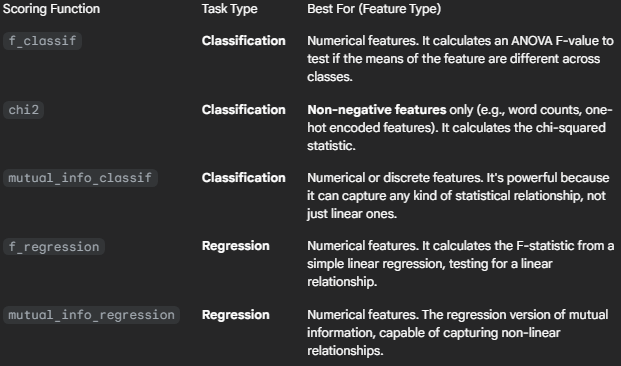

## RFE (Wrapper Method)


Think of this like a team competition where the weakest player is eliminated after each round. RFE uses the machine learning model (estimator) itself to decide which features are important. It works in a loop:

- Train the estimator on all current features.
- Rank the features based on their importance to the model (using the model's .coef_ or .feature_importances_ attribute).
- Eliminate the single least important feature.
- Repeat the process until the desired number of features is left.

The estimator is wrapped inside the selection process—hence the name "wrapper." The model's own performance is the "score" that determines which features survive.

- Key Parameter: estimator is the model that does the ranking.

**Classification**

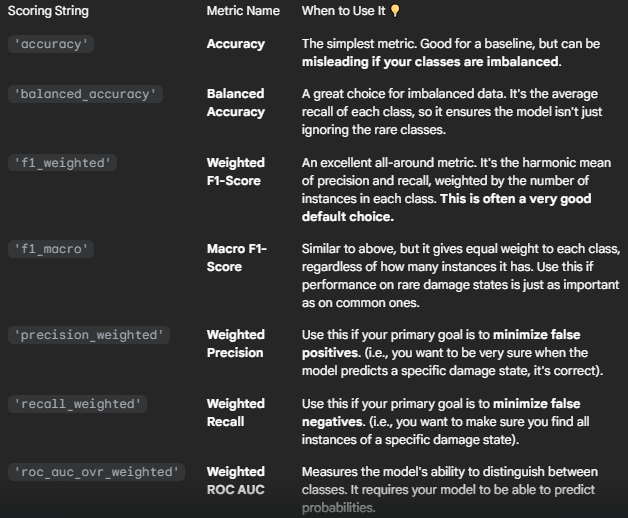

**Regression**

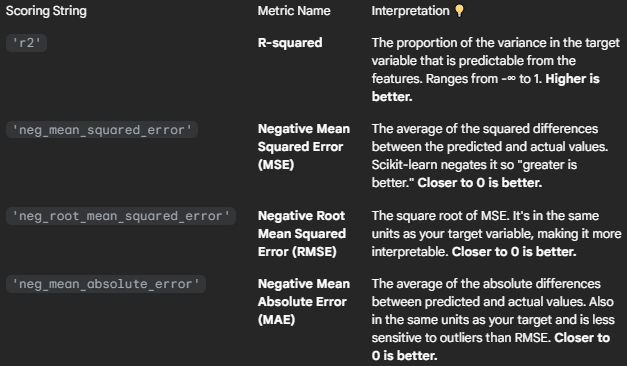

In [ ]:
from function_helper2 import rfe_evaluate_features_resampled

rfe_evaluate_features_resampled(X=X_train, 
                                y=y_train, 
                                model=model, 
                                scoring='recall_weighted',
                                  cv=5)

## SFS/SBS Feature Evaluation Function

In [ ]:
from function_helper2 import sffs_sbfs_evaluate_features_resampled

# Forward
forward = sffs_sbfs_evaluate_features_resampled(
    X=X_train, 
    y=y_train, 
    model=model,
    forward=True,
    floating=True, # Use True for SFFS, False for SFS
    cv=5
)


In [ ]:
forward

---

In [38]:
# Assume df is your DataFrame
X = df.drop(columns=['Building_ID', 'Damage_State']) 
y = df['Damage_State']

# targe variable is categorical ordinal data type (multi classification)
Damage_State_Mapping = {
    'No Damage': 0,
    'Light': 1,
    'Moderate': 2,
    'Severe': 3,
    'Collapse': 4
}

y_encoded = y.map(Damage_State_Mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [39]:
X_test

,Latitude,Longitude,PGA_g,PGV_cm_s,Year_Construction,Num_Stories,Structural_System,Soil_Type_Vs30_mps
60,10.3080,123.8995,0.55,59.0,2010,15,Reinforced Concrete,450
80,10.2895,123.8765,0.35,31.2,1963,3,Unreinforced Masonry,250
89,10.3475,123.9325,0.30,27.8,2020,6,Reinforced Concrete,800
10,10.3001,123.8902,0.48,46.3,1988,6,Reinforced Concrete,450
39,10.2940,123.8800,0.39,34.5,2018,2,Masonry (CHB),250
59,10.3310,123.9180,0.49,50.8,1983,4,Masonry (CHB),450
95,10.3158,123.8908,0.50,51.7,2004,13,Reinforced Concrete,450
79,10.3365,123.9225,0.46,46.5,2014,12,Reinforced Concrete,450
65,10.3005,123.8895,0.47,45.8,1987,5,Masonry (CHB),450
84,10.3138,123.9058,0.54,58.2,2017,25,Steel Frame,450
